In [191]:
import re
import joblib
from joblib import dump, load

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler, 
    OrdinalEncoder, 
    LabelEncoder, 
    OneHotEncoder,
    PolynomialFeatures
)

from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)

from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics as skmet

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    fbeta_score,
    roc_auc_score, 
    average_precision_score,
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay, 
    RocCurveDisplay, 
    precision_recall_curve,
)

import yellowbrick.model_selection as ms

import xgboost
from xgboost import XGBClassifier
from hyperopt.pyll.base import scope
from hyperopt import (
    fmin, 
    tpe, 
    hp, 
    STATUS_OK, 
    Trials
)

from typing import (
    Any, 
    Dict, 
    Union, 
    Sequence
)

pd.set_option('display.max_columns', None)
pd.options.plotting.backend = 'matplotlib'

In [192]:
color_palette = ["#CF2011", "#E42313", "#EB5A4E", "#F29189", "#FFFFFF", "#B8B7B7", "#706F6F", "#1D1D1B"]
fp = (matplotlib
      .font_manager
      .FontProperties(fname='/Fonts/roboto/Roboto-Condensed.ttf')
     )
sns.set_palette(color_palette)
sns.set_style("whitegrid", 
              {"grid.color": "#ffffff", 
               "axes.facecolor": "w", 
               "figure.facecolor":"white"})

In [2]:
df = (pd
      .read_csv('Telco_customer_churn_adapted_v2.csv')
     )

In [3]:
def get_var(df, var_name):
    globals()[var_name] = df
    return df

In [4]:
label_encoder = LabelEncoder()
df = (df
      .rename(columns={'Churn Label': 'churn_label'})
      .assign(churn_label=lambda df_: label_encoder.fit_transform(df_.churn_label))
      .astype({'churn_label': 'int8'})
     )
df

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),churn_label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,1,106.816666,-6.2,4210.7
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,1,106.816666,-6.2,3511.3
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,1,106.816666,-6.2,6983.6
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,1,106.816666,-6.2,6503.9
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,1,106.816666,-6.2,6942.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,72,Jakarta,Low End,No internet service,No internet service,No internet service,No,No internet service,No internet service,Debit,27.495,0,106.816666,-6.2,6897.8
7039,7039,24,Jakarta,Mid End,Yes,No,Yes,Yes,Yes,Yes,Digital Wallet,110.240,0,106.816666,-6.2,2782.0
7040,7040,72,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Credit,134.160,0,106.816666,-6.2,7228.0
7041,7041,11,Jakarta,Mid End,Yes,No,No,No,No,No,Pulsa,38.480,0,106.816666,-6.2,3630.9


In [5]:
class TweakCustomerChurn(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        digital_product_cols = ['games_product', 'music_product', 'education_product', 'video_product']
        all_product_cols = ['games_product', 'music_product', 'education_product', 'video_product', 'call_center', 'use_myapp']
        
        return (X
                .rename(columns=lambda col: re.compile(r'[^a-zA-Z0-9_]+').sub('_', col.lower()))
                .assign(tenure_segmentation=lambda df_: np.where(df_.tenure_months < 4, "low", np.where(df_.tenure_months < 12, "medium", "high")),
                        any_digital_product=lambda df_: np.where((df_.games_product == "Yes") | (df_.music_product == "Yes") | (df_.education_product == "Yes") | (df_.video_product == "Yes"), 1, 0),
                        all_digital_product=lambda df_: np.where((df_.games_product == "Yes") & (df_.music_product == "Yes") & (df_.education_product == "Yes") & (df_.video_product == "Yes"), 1, 0),
                        total_digital_product_used=lambda df_: df_[digital_product_cols].apply(lambda row: sum(row == 'Yes'), axis=1),
                        total_product_utilisation=lambda df_: df_[all_product_cols].apply(lambda row: sum(row == 'Yes'), axis=1),
                        total_spending=lambda df_: df_.tenure_months.mul(df_.monthly_purchase_thou_idr_),
                        net_cltv_total_spending=lambda df_: df_.cltv_predicted_thou_idr_.sub(df_.total_spending)
                        ) 
                .astype({**{k: "int8"
                            for k in ["tenure_months", "any_digital_product", "all_digital_product", "total_digital_product_used", "total_product_utilisation"]},
                         **{k: "float16"
                            for k in ["monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending", "net_cltv_total_spending"]},
                         **{k: "category"
                            for k in ["tenure_segmentation", "location", "device_class", "games_product", "music_product", "education_product", "call_center", "video_product", "use_myapp", "payment_method"]}})
                .reindex(columns=["churn_label", "tenure_months", "tenure_segmentation", "location", "device_class", "games_product", "music_product", "education_product", "video_product", "any_digital_product", "all_digital_product", "total_digital_product_used", "call_center", "use_myapp", "total_product_utilisation", "payment_method", "monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending", "net_cltv_total_spending"])
               )

In [6]:
(TweakCustomerChurn()
 .transform(df)
)

,churn_label,tenure_months,tenure_segmentation,location,device_class,games_product,music_product,education_product,video_product,any_digital_product,all_digital_product,total_digital_product_used,call_center,use_myapp,total_product_utilisation,payment_method,monthly_purchase_thou_idr_,cltv_predicted_thou_idr_,total_spending,net_cltv_total_spending
0,1,2,low,Jakarta,Mid End,Yes,Yes,No,No,1,0,2,No,No,2,Digital Wallet,70.00000,4212.0,140.000,4070.00
1,1,2,low,Jakarta,High End,No,No,No,No,0,0,0,No,No,0,Pulsa,91.93750,3512.0,183.875,3328.00
2,1,8,medium,Jakarta,High End,No,No,Yes,Yes,1,0,2,No,Yes,3,Pulsa,129.50000,6984.0,1036.000,5948.00
3,1,28,high,Jakarta,High End,No,No,Yes,Yes,1,0,2,Yes,Yes,4,Pulsa,136.25000,6504.0,3814.000,2690.00
4,1,49,high,Jakarta,High End,No,Yes,Yes,Yes,1,0,3,No,Yes,4,Debit,134.75000,6944.0,6604.000,336.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,72,high,Jakarta,Low End,No internet service,No internet service,No internet service,No internet service,0,0,0,No,No internet service,0,Debit,27.50000,6896.0,1980.000,4920.00
7039,0,24,high,Jakarta,Mid End,Yes,No,Yes,Yes,1,0,3,Yes,Yes,5,Digital Wallet,110.25000,2782.0,2646.000,136.25
7040,0,72,high,Jakarta,High End,No,Yes,Yes,Yes,1,0,3,No,Yes,4,Credit,134.12500,7228.0,9656.000,-2432.00
7041,0,11,medium,Jakarta,Mid End,Yes,No,No,No,1,0,1,No,No,1,Pulsa,38.46875,3630.0,423.250,3208.00


In [7]:
(TweakCustomerChurn()
 .transform(df)
 .loc[lambda df_: df_.churn_label==1]
 .iloc[:, 1:]
 .to_csv('churn_only.csv', index=False)
)

In [8]:
churn_only = (pd
              .read_csv('churn_only.csv')
             )
churn_only

,tenure_months,tenure_segmentation,location,device_class,games_product,music_product,education_product,video_product,any_digital_product,all_digital_product,total_digital_product_used,call_center,use_myapp,total_product_utilisation,payment_method,monthly_purchase_thou_idr_,cltv_predicted_thou_idr_,total_spending,net_cltv_total_spending
0,2,low,Jakarta,Mid End,Yes,Yes,No,No,1,0,2,No,No,2,Digital Wallet,70.00,4212.0,140.0,4070.0
1,2,low,Jakarta,High End,No,No,No,No,0,0,0,No,No,0,Pulsa,91.94,3512.0,183.9,3328.0
2,8,medium,Jakarta,High End,No,No,Yes,Yes,1,0,2,No,Yes,3,Pulsa,129.50,6984.0,1036.0,5948.0
3,28,high,Jakarta,High End,No,No,Yes,Yes,1,0,2,Yes,Yes,4,Pulsa,136.20,6504.0,3814.0,2690.0
4,49,high,Jakarta,High End,No,Yes,Yes,Yes,1,0,3,No,Yes,4,Debit,134.80,6944.0,6604.0,336.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,12,high,Jakarta,Mid End,No,No,No,Yes,1,0,1,Yes,No,2,Pulsa,77.75,5956.0,933.0,5024.0
1865,9,medium,Jakarta,Mid End,No,No,No,No,0,0,0,No,No,0,Debit,57.47,2638.0,517.0,2120.0
1866,1,low,Jakarta,High End,No,No,No,No,0,0,0,No,No,0,Pulsa,98.50,7244.0,98.5,7144.0
1867,67,high,Jakarta,High End,Yes,Yes,Yes,Yes,1,1,4,No,No,4,Credit,133.90,7304.0,8970.0,-1661.0


In [9]:
standard_numerical_features = ['net_cltv_total_spending']
standard_numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

ohe_categorical_features = ['location', 'device_class', 'games_product', 'music_product', 'education_product', 'video_product', 'call_center', 'use_myapp', 'payment_method']
ohe_categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

orde_categorical_features = ['tenure_segmentation']
orde_categorical_transformer = Pipeline(steps=[
    ('orde', OrdinalEncoder(dtype='float'))
])

col_trans = ColumnTransformer(
    transformers=[
        ('standard_numerical_features', standard_numerical_transformer, standard_numerical_features),
        ('ohe_categorical_features', ohe_categorical_transformer, ohe_categorical_features),
        ('orde_categorical_features', orde_categorical_transformer, orde_categorical_features),
    ], 
    remainder='passthrough', 
    verbose=0, 
    verbose_feature_names_out=False,)

In [10]:
col_trans.fit_transform(TweakCustomerChurn().transform(churn_only).iloc[:, 1:])

array([[ 2.57568359e-01,  1.00000000e+00,  0.00000000e+00, ...,
         7.00000000e+01,  4.21200000e+03,  1.40000000e+02],
       [-2.89306641e-02,  1.00000000e+00,  0.00000000e+00, ...,
         9.19375000e+01,  3.51200000e+03,  1.83875000e+02],
       [ 9.79492188e-01,  1.00000000e+00,  0.00000000e+00, ...,
         1.29500000e+02,  6.98400000e+03,  1.03600000e+03],
       ...,
       [ 1.44042969e+00,  1.00000000e+00,  0.00000000e+00, ...,
         9.85000000e+01,  7.24400000e+03,  9.85000000e+01],
       [-1.95312500e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.33875000e+02,  7.30400000e+03,  8.96800000e+03],
       [ 1.46289062e+00,  1.00000000e+00,  0.00000000e+00, ...,
         9.67500000e+01,  7.59200000e+03,  3.87000000e+02]])

In [11]:
TweakCustomerChurn().transform(churn_only).iloc[:, 1:].columns.tolist()

['tenure_months',
 'tenure_segmentation',
 'location',
 'device_class',
 'games_product',
 'music_product',
 'education_product',
 'video_product',
 'any_digital_product',
 'all_digital_product',
 'total_digital_product_used',
 'call_center',
 'use_myapp',
 'total_product_utilisation',
 'payment_method',
 'monthly_purchase_thou_idr_',
 'cltv_predicted_thou_idr_',
 'total_spending',
 'net_cltv_total_spending']

In [12]:
len(col_trans.get_feature_names_out(input_features=TweakCustomerChurn().transform(churn_only).iloc[:, 1:].columns.tolist()))

27

In [13]:
pd.DataFrame(col_trans.fit_transform(TweakCustomerChurn().transform(churn_only).iloc[:, 1:]), 
             columns=col_trans.get_feature_names_out(input_features=TweakCustomerChurn().transform(churn_only).iloc[:, 1:].columns.tolist()))

,net_cltv_total_spending,location_Jakarta,device_class_Low End,device_class_Mid End,games_product_No internet service,games_product_Yes,music_product_No internet service,music_product_Yes,education_product_No internet service,education_product_Yes,video_product_No internet service,video_product_Yes,call_center_Yes,use_myapp_No internet service,use_myapp_Yes,payment_method_Debit,payment_method_Digital Wallet,payment_method_Pulsa,tenure_segmentation,tenure_months,any_digital_product,all_digital_product,total_digital_product_used,total_product_utilisation,monthly_purchase_thou_idr_,cltv_predicted_thou_idr_,total_spending
0,0.257568,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,2.0,70.00000,4212.0,140.000
1,-0.028931,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,91.93750,3512.0,183.875
2,0.979492,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,8.0,1.0,0.0,2.0,3.0,129.50000,6984.0,1036.000
3,-0.274658,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,28.0,1.0,0.0,2.0,4.0,136.25000,6504.0,3814.000
4,-1.179688,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,49.0,1.0,0.0,3.0,4.0,134.75000,6944.0,6604.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,0.624023,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.0,0.0,1.0,2.0,77.75000,5956.0,933.000
1865,-0.494141,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,9.0,0.0,0.0,0.0,0.0,57.46875,2638.0,517.000
1866,1.440430,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,98.50000,7244.0,98.500
1867,-1.953125,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,1.0,1.0,4.0,4.0,133.87500,7304.0,8968.000


In [14]:
transformed_churned = pd.DataFrame(col_trans.fit_transform(TweakCustomerChurn().transform(churn_only).iloc[:, 1:]), 
                                   columns=col_trans.get_feature_names_out(input_features=TweakCustomerChurn().transform(churn_only).iloc[:, 1:].columns.tolist()))

In [15]:
transformed_churned_drop = transformed_churned.drop(columns=["tenure_months", "monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending"])

In [16]:
def delcorr(df, y=''):
    #delete any x too highly correlated with another x, to avoid collinearity
    
    if y == '':
        #assume 1st column is y
        y = df.columns[-1]
    corv = df.drop(y, axis=1).corrwith(df[y]).rename(y).sort_values(key=abs).to_frame() #corr(Xs, y) ranked

    delta = 0.005 #corr difference lower limit
    dl2 = []
    icorr = True
    while icorr:
        a = abs(corv).diff() <= delta #adjacent rows with similar abs(corr(Xs, y))
        colname = list(df)[1:]
        dl = []
        print('\nX pairs with correlations >', 1 - delta, ':')
        for b in range(1, a.shape[0]):
            if a.iloc[b, 0]:
                if abs(df[a.index[b - 1]].corr(df[a.index[b]])) > 1 - delta:
                    #deleting 1 X from correlated pair:
                    dv0 = a.index[b - 1]
                    dv1 = a.index[b]

                    #neither should already be deleted:
                    if not (dv0 in dl) and not (dv1 in dl):
                        #delete x with rather lower corr(x, y):
                        if abs(corv.loc[dv0, y]) - abs(corv.loc[dv1, y]) >= delta:
                            d = dv1
                        elif len(dv0) < len(dv1): #delete x with longer name:
                            d = dv1
                        else:
                            d = dv0

                        dl.append(d) #for en masse deletion later
                        corv.drop([d], axis=0, inplace=True) #delete from column of corr with y

                        print(dv0, ',', dv1)

        if len(dl) > 0:
            df.drop(axis=1, columns=dl, inplace=True) #variables deleted en masse
            dl2 = dl2 + dl #keep for real deletion later
            print('\n' + str(len(dl)), 'variables considered for deletion:')
            print('\n'.join([str(x) for x in dl]))
        else:
            print('(no more)')
            icorr = False
    return dl2

In [17]:
df0 = transformed_churned_drop.copy()
transformed_churned_remove_multicol = delcorr(df0) #find collinearity deletion candidates among original & transformed variables


X pairs with correlations > 0.995 :
video_product_No internet service , device_class_Low End
device_class_Low End , games_product_No internet service
music_product_No internet service , education_product_No internet service

3 variables considered for deletion:
video_product_No internet service
games_product_No internet service
education_product_No internet service

X pairs with correlations > 0.995 :
device_class_Low End , music_product_No internet service

1 variables considered for deletion:
music_product_No internet service

X pairs with correlations > 0.995 :
device_class_Low End , use_myapp_No internet service

1 variables considered for deletion:
use_myapp_No internet service

X pairs with correlations > 0.995 :
(no more)


In [18]:
transformed_churned_remove_multicol

['video_product_No internet service',
 'games_product_No internet service',
 'education_product_No internet service',
 'music_product_No internet service',
 'use_myapp_No internet service']

In [19]:
df0

,net_cltv_total_spending,location_Jakarta,device_class_Low End,device_class_Mid End,games_product_Yes,music_product_Yes,education_product_Yes,video_product_Yes,call_center_Yes,use_myapp_Yes,payment_method_Debit,payment_method_Digital Wallet,payment_method_Pulsa,tenure_segmentation,any_digital_product,all_digital_product,total_digital_product_used,total_product_utilisation
0,0.257568,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0
1,-0.028931,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.979492,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,3.0
3,-0.274658,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,4.0
4,-1.179688,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,0.624023,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
1865,-0.494141,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1866,1.440430,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1867,-1.953125,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,4.0


In [20]:
import statsmodels.api as sm

# The dependent variable
Y = StandardScaler().fit_transform(df0['net_cltv_total_spending'].to_frame())

# The independent variables, add a constant to include an intercept in the model
X = df0.iloc[:, 1:]
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

In [21]:
# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     106.9
Date:                Fri, 10 Nov 2023   Prob (F-statistic):          1.08e-237
Time:                        00:00:07   Log-Likelihood:                -2069.5
No. Observations:                1869   AIC:                             4171.
Df Residuals:                    1853   BIC:                             4259.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [26]:
df0.head()

,net_cltv_total_spending,location_Jakarta,device_class_Low End,device_class_Mid End,games_product_Yes,music_product_Yes,education_product_Yes,video_product_Yes,call_center_Yes,use_myapp_Yes,payment_method_Debit,payment_method_Digital Wallet,payment_method_Pulsa,tenure_segmentation,any_digital_product,all_digital_product,total_digital_product_used,total_product_utilisation
0,0.257568,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0
1,-0.028931,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.979492,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,3.0
3,-0.274658,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,4.0
4,-1.179688,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0


# XGBoost

In [46]:
col_trans_xgb = ColumnTransformer(
    transformers=[
        ('ohe_categorical_features', ohe_categorical_transformer, ohe_categorical_features),
        ('orde_categorical_features', orde_categorical_transformer, orde_categorical_features),
    ], 
    remainder='passthrough', 
    verbose=0, 
    verbose_feature_names_out=False,)

In [47]:
col_trans_xgb.fit_transform(TweakCustomerChurn().transform(churn_only).iloc[:, 1:])

array([[ 1.00000e+00,  0.00000e+00,  1.00000e+00, ...,  4.21200e+03,
         1.40000e+02,  4.07200e+03],
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00, ...,  3.51200e+03,
         1.83875e+02,  3.32800e+03],
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00, ...,  6.98400e+03,
         1.03600e+03,  5.94800e+03],
       ...,
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.24400e+03,
         9.85000e+01,  7.14400e+03],
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.30400e+03,
         8.96800e+03, -1.66700e+03],
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.59200e+03,
         3.87000e+02,  7.20400e+03]])

In [48]:
transformed_churned_xgb = pd.DataFrame(col_trans_xgb.fit_transform(TweakCustomerChurn().transform(churn_only).iloc[:, 1:]), 
                                       columns=col_trans_xgb.get_feature_names_out(input_features=TweakCustomerChurn().transform(churn_only).iloc[:, 1:].columns.tolist()))

In [49]:
transformed_churned_drop = transformed_churned_xgb.drop(columns=["tenure_months", "monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending"])

In [50]:
df0_xgb = transformed_churned_drop.copy()
transformed_churned_xgb_remove_multicol = delcorr(df0_xgb) #find collinearity deletion candidates among original & transformed variables


X pairs with correlations > 0.995 :
games_product_No internet service , music_product_No internet service
music_product_No internet service , education_product_No internet service
video_product_No internet service , use_myapp_No internet service
use_myapp_No internet service , device_class_Low End

4 variables considered for deletion:
games_product_No internet service
education_product_No internet service
video_product_No internet service
use_myapp_No internet service

X pairs with correlations > 0.995 :
music_product_No internet service , device_class_Low End

1 variables considered for deletion:
music_product_No internet service

X pairs with correlations > 0.995 :
(no more)


In [51]:
df0_xgb

,location_Jakarta,device_class_Low End,device_class_Mid End,games_product_Yes,music_product_Yes,education_product_Yes,video_product_Yes,call_center_Yes,use_myapp_Yes,payment_method_Debit,payment_method_Digital Wallet,payment_method_Pulsa,tenure_segmentation,any_digital_product,all_digital_product,total_digital_product_used,total_product_utilisation,net_cltv_total_spending
0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,4072.00
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3328.00
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,3.0,5948.00
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,4.0,2690.00
4,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,338.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,5024.00
1865,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2120.00
1866,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,7144.00
1867,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,4.0,-1667.00


In [52]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [54]:
# Assuming df is your DataFrame and the last column is the target variable
X_xgb, y_xgb = df0_xgb.iloc[:, :-1], df0_xgb.iloc[:, -1]

# Split the dataset into train and test sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

In [55]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror',
                          seed=42,
                          n_jobs=-1)

In [56]:
# Fit the regressor to the training set
xg_reg.fit(X_train_xgb, y_train_xgb)

# Predict the labels of the test set
y_pred_xgb = xg_reg.predict(X_test_xgb)

# Compute and print the mean squared error of the predictions
mse_xgb = mean_squared_error(y_test_xgb, y_pred_xgb)
print(f"Mean Squared Error: {mse_xgb}")

Mean Squared Error: 3670856.3642991125


In [57]:
np.sqrt(3670856.3642991125)

1915.9479022925211

In [59]:
# def hyperparameter_tuning(space: Dict[str, Union[float, int]],
#                           X_train: pd.DataFrame, 
#                           y_train: pd.Series,
#                           X_test: pd.DataFrame,
#                           y_test: pd.Series,
#                           early_stopping_rounds: int=50,
#                           metric:callable=mean_squared_error) -> Dict[str, Any]: #accuracy_score
    
#     int_vals = ['max_depth']
#     space = {k: (int (val) if k in int_vals else val)
#              for k, val in space.items()}
#     space['early_stopping_rounds'] = early_stopping_rounds
    
#     model = XGBClassifier(**space, 
#                           eval_metric=['rmse'],
#                           seed=42,
#                           n_jobs=-1)
    
#     model.fit(X_train_xgb, 
#               y_train_xgb, 
#               eval_set=[(X_train_xgb, y_train_xgb),
#                         (X_test_xgb, y_test_xgb)],
#               verbose=False)
    
#     pred = model.predict(X_test_xgb)
#     score = metric(y_test_xgb, pred, squared=False)
    
#     return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [76]:
options = {'n_estimators': hp.choice('n_estimators', [250, 500, 1000]),
           'max_depth': scope.to_int(hp.quniform('max_depth', 3, 12, 1)),
           'min_child_weight': hp.loguniform('min_child_weight', -1, 1),
           'subsample': hp.uniform('subsample', 0.5, 1),
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 100),
           'reg_lambda': hp.uniform('reg_lambda', 1, 100),
           'gamma': hp.loguniform('gamma', -10, 10),
           'learning_rate': hp.loguniform('learning_rate', -7, 0),
           'random_state': 42
          }

In [77]:
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_child_weight': int(params['min_child_weight']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'gamma': params['gamma'],
        'learning_rate': params['learning_rate'],
        'objective': 'reg:squarederror'
    }
    
    # Instantiate the XGBoost regressor
    xgb_reg = xgb.XGBRegressor(**params)
    
    # Perform cross-validation
    score = -cross_val_score(xgb_reg, X_xgb, y_xgb, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    
    # Dictionary with information for Hyperopt
    return {'loss': score, 'status': STATUS_OK}

In [64]:
@scope.define
def to_int(x):
    return int(x)

In [78]:
trials = Trials()
SEED=101

xgb_best_params = fmin(fn=objective,
                       space=options,
                       algo=tpe.suggest,
                       max_evals=500,
                       trials=trials,
                       rstate=np.random.default_rng(SEED))

100%|████████| 500/500 [05:30<00:00,  1.51trial/s, best loss: 3104429.666330805]


In [79]:
xgb_best_params

{'colsample_bytree': 0.9642935118849765,
 'gamma': 0.013143232654780825,
 'learning_rate': 0.006369390076039691,
 'max_depth': 3.0,
 'min_child_weight': 0.836268846286638,
 'n_estimators': 2,
 'reg_alpha': 23.747592315383145,
 'reg_lambda': 2.0963021382302665,
 'subsample': 0.8690797777024094}

In [80]:
xgb_best_params = {
    'n_estimators': [250, 500, 1000][xgb_best_params['n_estimators']],
    'colsample_bytree': xgb_best_params['colsample_bytree'],
    'gamma': xgb_best_params['gamma'],
    'learning_rate': xgb_best_params['learning_rate'],
    'max_depth': int(xgb_best_params['max_depth']),
    'min_child_weight': xgb_best_params['min_child_weight'],
    'reg_alpha': xgb_best_params['reg_alpha'],
    'reg_lambda': xgb_best_params['reg_lambda'],
    'subsample': xgb_best_params['subsample']
}

In [81]:
xgb_best_params

{'n_estimators': 1000,
 'colsample_bytree': 0.9642935118849765,
 'gamma': 0.013143232654780825,
 'learning_rate': 0.006369390076039691,
 'max_depth': 3,
 'min_child_weight': 0.836268846286638,
 'reg_alpha': 23.747592315383145,
 'reg_lambda': 2.0963021382302665,
 'subsample': 0.8690797777024094}

In [82]:
xgb_clf_tuned = xgb.XGBRegressor(**xgb_best_params, 
                                objective='reg:squarederror', 
                                seed=42)

xgb_clf_tuned.fit(X_train_xgb, y_train_xgb)
y_pred = xgb_clf_tuned.predict(X_test_xgb)

In [177]:
mean_squared_error(y_test_xgb, y_pred, squared=False)

1699.8635996884411

In [97]:
y_test_xgb

1700     531.5000
1488    6000.0000
921     4058.0000
275     6288.0000
416     5732.0000
          ...    
439     -104.0625
1296    6492.0000
374     3560.0000
271     2488.0000
184     4512.0000
Name: net_cltv_total_spending, Length: 374, dtype: float64

In [175]:
result = pd.DataFrame([y_test_xgb.reset_index(drop=True), y_pred]).T.rename(columns={'net_cltv_total_spending': 'y_test', 'Unnamed 0': 'y_pred'})

<Axes: >

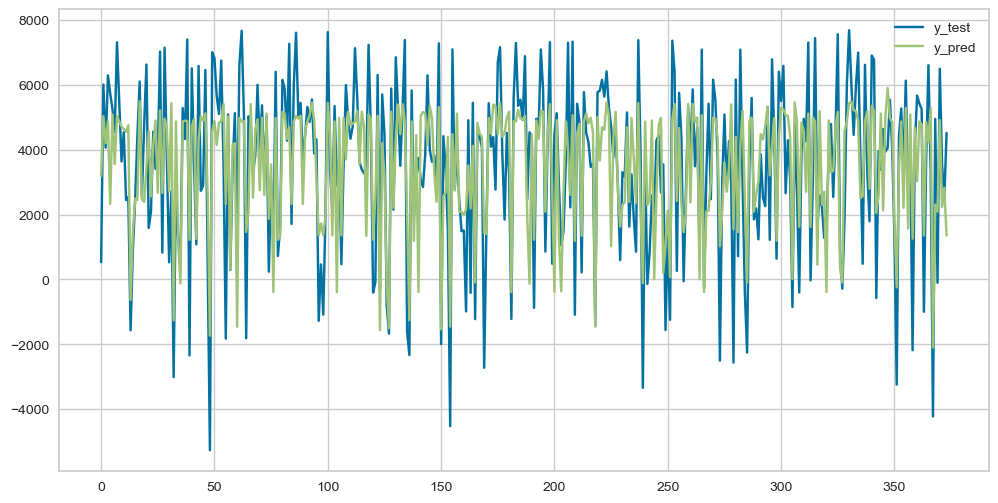

In [176]:
fig, ax = plt.subplots(figsize=(12,6))
(result
 .reset_index(drop=True)
 .plot
 .line(ax=ax)
)

In [183]:
import seaborn.objects as so

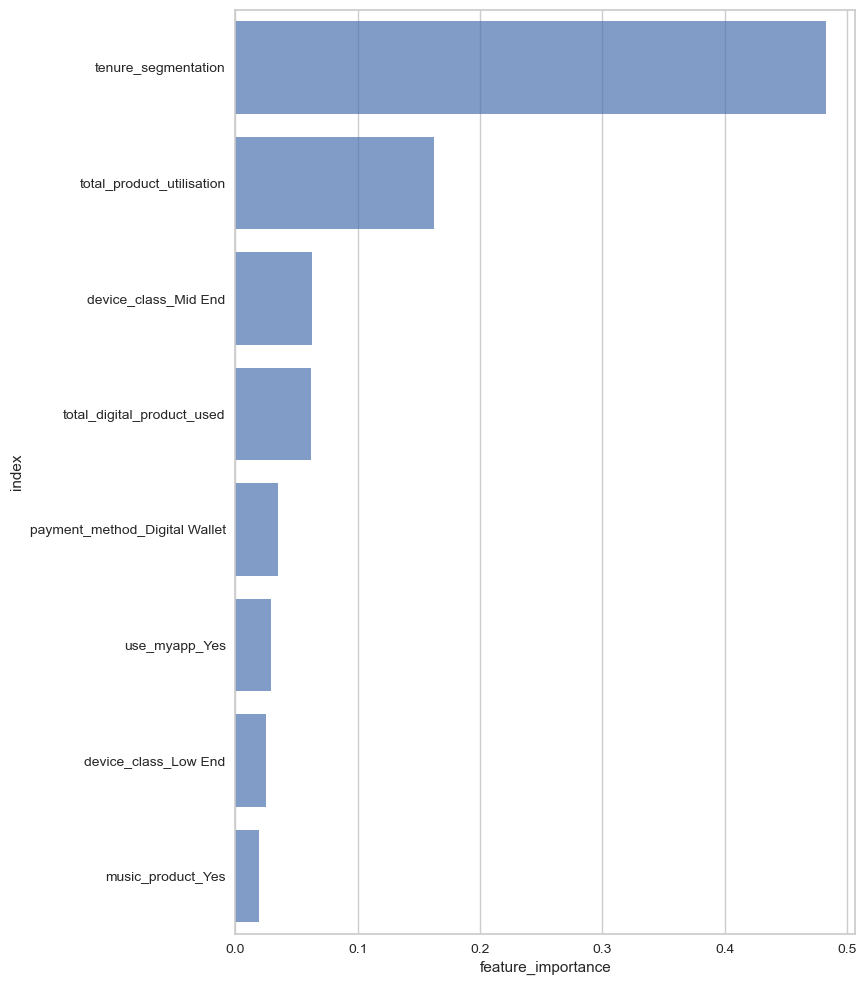

In [186]:
fig.clf()
fig, ax = plt.subplots(figsize=(8, 12))
(so
 .Plot((pd
      .DataFrame(xgb_clf_tuned.feature_importances_, index=X_xgb.columns.tolist())
      .rename(columns={0: "feature_importance"})
      .sort_values(by="feature_importance", ascending=False)
      .iloc[:8, :]
      .reset_index()),
     x='feature_importance',
     y='index'
    )
 .add(so.Bar(edgewidth=0))
 # .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[2]])})
 .on(ax)
 .show())

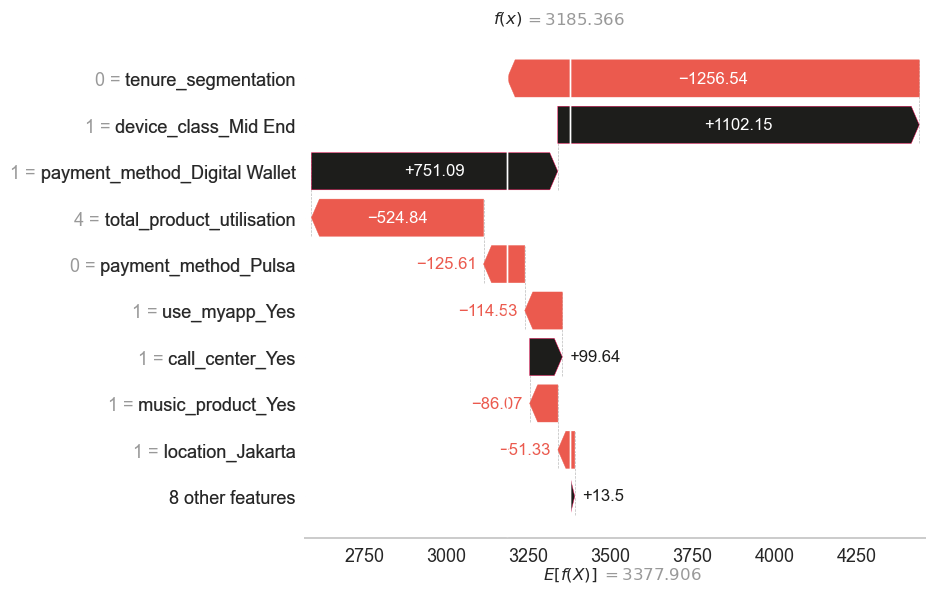

In [195]:
default_pos_color = "#ff0051"
default_neg_color = "#008bfb"

# Custom colors
positive_color = color_palette[7]
negative_color = color_palette[2]

fig = plt.figure(figsize=(8,4))
fig = shap.plots.waterfall(vals[0], show=False)
        
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if (isinstance(fcc, matplotlib.patches.FancyArrow)):
            if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
                fcc.set_facecolor(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
                fcc.set_color(negative_color)
        elif (isinstance(fcc, plt.Text)):
            if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
                fcc.set_color(positive_color)
            elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
                fcc.set_color(negative_color)

fig

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


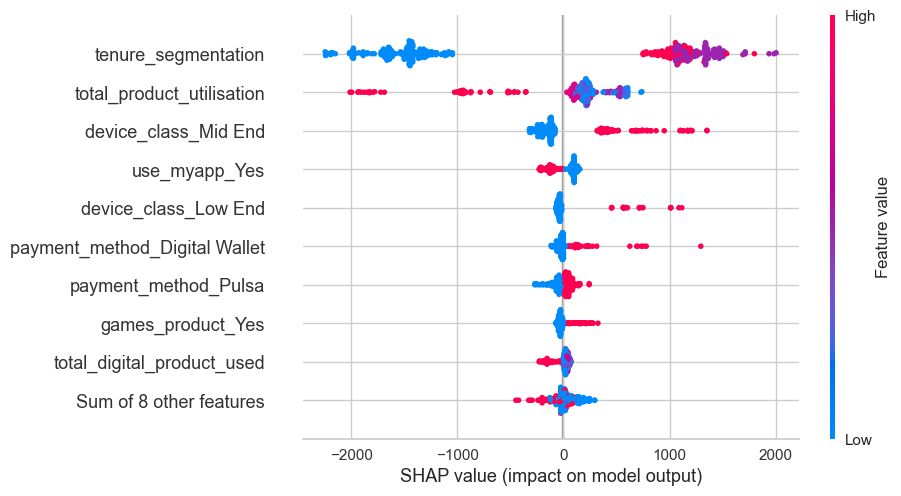

In [188]:
import shap
shap_ex = shap.TreeExplainer(xgb_clf_tuned)
vals = shap_ex(pd.DataFrame(X_test_xgb, columns=X_xgb.columns.tolist()))

shap_df = pd.DataFrame(vals.values, columns=X_xgb.columns.tolist())
shap_df

fig = plt.figure(figsize=(8, 4))
fig = shap.plots.beeswarm(vals)
fig;

# Random Forest

In [121]:
from sklearn.ensemble import RandomForestRegressor

In [110]:
col_trans_rf = ColumnTransformer(
    transformers=[
        ('ohe_categorical_features', ohe_categorical_transformer, ohe_categorical_features),
        ('orde_categorical_features', orde_categorical_transformer, orde_categorical_features),
    ], 
    remainder='passthrough', 
    verbose=0, 
    verbose_feature_names_out=False,)

In [111]:
col_trans_rf.fit_transform(TweakCustomerChurn().transform(churn_only).iloc[:, 1:])

array([[ 1.00000e+00,  0.00000e+00,  1.00000e+00, ...,  4.21200e+03,
         1.40000e+02,  4.07200e+03],
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00, ...,  3.51200e+03,
         1.83875e+02,  3.32800e+03],
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00, ...,  6.98400e+03,
         1.03600e+03,  5.94800e+03],
       ...,
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.24400e+03,
         9.85000e+01,  7.14400e+03],
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.30400e+03,
         8.96800e+03, -1.66700e+03],
       [ 1.00000e+00,  0.00000e+00,  0.00000e+00, ...,  7.59200e+03,
         3.87000e+02,  7.20400e+03]])

In [112]:
transformed_churned_rf = pd.DataFrame(col_trans_rf.fit_transform(TweakCustomerChurn().transform(churn_only).iloc[:, 1:]), 
                                       columns=col_trans_rf.get_feature_names_out(input_features=TweakCustomerChurn().transform(churn_only).iloc[:, 1:].columns.tolist()))

In [113]:
transformed_churned_drop_rf = transformed_churned_rf.drop(columns=["tenure_months", "monthly_purchase_thou_idr_", "cltv_predicted_thou_idr_", "total_spending"])

In [114]:
df0_rf = transformed_churned_drop_rf.copy()
transformed_churned_rf_remove_multicol = delcorr(df0_rf) #find collinearity deletion candidates among original & transformed variables


X pairs with correlations > 0.995 :
games_product_No internet service , music_product_No internet service
music_product_No internet service , education_product_No internet service
video_product_No internet service , use_myapp_No internet service
use_myapp_No internet service , device_class_Low End

4 variables considered for deletion:
games_product_No internet service
education_product_No internet service
video_product_No internet service
use_myapp_No internet service

X pairs with correlations > 0.995 :
music_product_No internet service , device_class_Low End

1 variables considered for deletion:
music_product_No internet service

X pairs with correlations > 0.995 :
(no more)


In [115]:
df0_rf

,location_Jakarta,device_class_Low End,device_class_Mid End,games_product_Yes,music_product_Yes,education_product_Yes,video_product_Yes,call_center_Yes,use_myapp_Yes,payment_method_Debit,payment_method_Digital Wallet,payment_method_Pulsa,tenure_segmentation,any_digital_product,all_digital_product,total_digital_product_used,total_product_utilisation,net_cltv_total_spending
0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0,4072.00
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3328.00
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,3.0,5948.00
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,4.0,2690.00
4,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,4.0,338.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,5024.00
1865,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2120.00
1866,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,7144.00
1867,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,4.0,-1667.00


In [144]:
# Assuming df is your DataFrame and the last column is the target variable
X_rf, y_rf = df0_xgb.iloc[:, :-1], df0_rf.iloc[:, -1]

# Split the dataset into train and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

In [145]:
rf_reg = RandomForestRegressor(random_state=42,
                               n_jobs=-1)

In [146]:
# Fit the regressor to the training set
rf_reg.fit(X_train_rf, y_train_rf)

# Predict the labels of the test set
y_pred_rf = rf_reg.predict(X_test_rf)

# Compute and print the mean squared error of the predictions
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
print(f"Mean Squared Error: {mse_rf}")

Mean Squared Error: 3393813.495796655


In [147]:
mean_squared_error(y_test_rf, y_pred_rf, squared=False)

1842.230576175701

In [148]:
options = {
    'n_estimators': hp.choice('n_estimators', [100, 250, 500]),
    'max_depth': scope.to_int(hp.quniform('max_depth', 5, 15, 1)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'max_leaf_nodes': scope.to_int(hp.quniform('max_leaf_nodes', 10, 100, 1)),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0.0, 0.5),
}

In [149]:
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_leaf_nodes': int(params['max_leaf_nodes']),
        'min_impurity_decrease': params['min_impurity_decrease'],
    }
    
    rf = RandomForestRegressor(**params)
    best_score = cross_val_score(rf, X_train_rf, y_train_rf, scoring='neg_mean_squared_error', cv=5).mean()
    return {'loss': -best_score, 'status': STATUS_OK}

In [151]:
@scope.define
def to_int(x):
    return int(x)

In [164]:
trials = Trials()
SEED=101

rf_best_params = fmin(fn=objective,
                       space=options,
                       algo=tpe.suggest,
                       max_evals=500,
                       trials=trials,
                       rstate=np.random.default_rng(SEED))

100%|████████| 500/500 [06:27<00:00,  1.29trial/s, best loss: 3705167.339013763]


In [165]:
rf_best_params

{'max_depth': 15.0,
 'max_leaf_nodes': 70.0,
 'min_impurity_decrease': 0.27052587297149,
 'min_samples_leaf': 0.10743791766744773,
 'min_samples_split': 0.10306310617999168,
 'n_estimators': 1}

In [166]:
rf_best_params = {
    'n_estimators': [100, 250, 500][rf_best_params['n_estimators']],
    'max_depth': int(rf_best_params['max_depth']),
    'min_samples_split': rf_best_params['min_samples_split'],
    'min_samples_leaf': rf_best_params['min_samples_leaf'],
    'max_leaf_nodes': int(rf_best_params['max_leaf_nodes']),
    'min_impurity_decrease': rf_best_params['min_impurity_decrease']
}

In [167]:
rf_best_params

{'n_estimators': 250,
 'max_depth': 15,
 'min_samples_split': 0.10306310617999168,
 'min_samples_leaf': 0.10743791766744773,
 'max_leaf_nodes': 70,
 'min_impurity_decrease': 0.27052587297149}

In [168]:
rf_clf_tuned = RandomForestRegressor(**rf_best_params, 
                                     random_state=42,
                                     n_jobs=-1)

rf_clf_tuned.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_clf_tuned.predict(X_test_rf)

In [170]:
mean_squared_error(y_test_rf, y_pred_rf, squared=False)

1792.8070624274965

In [171]:
y_test_rf

1700     531.5000
1488    6000.0000
921     4058.0000
275     6288.0000
416     5732.0000
          ...    
439     -104.0625
1296    6492.0000
374     3560.0000
271     2488.0000
184     4512.0000
Name: net_cltv_total_spending, Length: 374, dtype: float64

In [172]:
result = pd.DataFrame([y_test_rf.reset_index(drop=True), y_pred_rf]).T.rename(columns={'net_cltv_total_spending': 'y_test', 'Unnamed 0': 'y_pred'})

<Axes: >

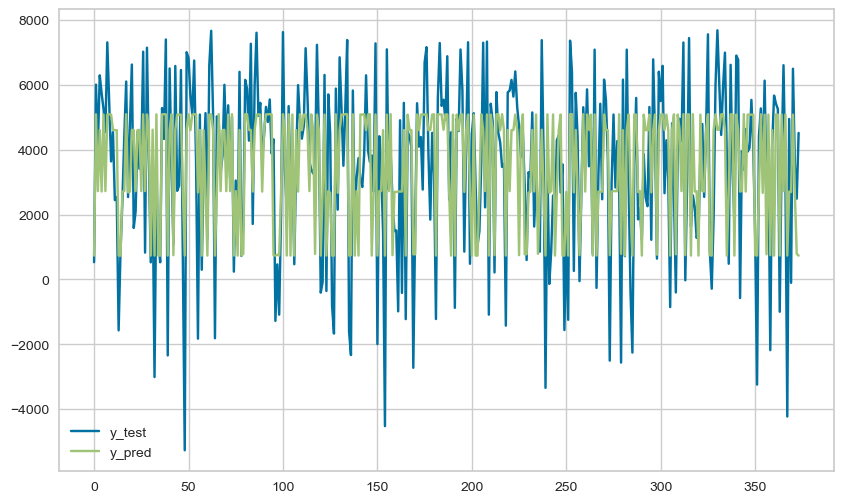

In [173]:
fig, ax = plt.subplots(figsize=(10,6))
(result
 .reset_index(drop=True)
 .plot
 .line(ax=ax)
)